In [39]:
import gym
import random, math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
from scripts.reinforce_rwd2go import rollout, make_pref_dataset
from scripts.utils import pref_save, pref_load

from scripts.model import getPolicy
import pickle
from scripts.reinforce_rwd2go import reinforce_rwd2go_2

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [40]:
SEED=0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

ENV_NAME = 'CartPole-v0'

env = gym.make(ENV_NAME)

K = 1000

In [41]:
policy = getPolicy(ENV_NAME=ENV_NAME).to(device)
opt = optim.Adam(policy.parameters(), lr=1e-2)

print("=== Training π₁ to get π₁ and π₂ ===")
scores, step_policy2_point, step_policy2_mean, step_policy2_both, step_policy1 = reinforce_rwd2go_2(env, policy, opt, env, n_episodes=2000, print_every=100, near_max_reward=195)

=== Training π₁ to get π₁ and π₂ ===
(Current) Half target policy saved at ep 68 with reward=109.0 and avg=35.3
(Mean) Half target policy saved at ep 74 with mean reward = 107.9 over 10 last ep and avg=43.2)
(Current-Mean) Half target policy saved at ep 76 with mean reward = 120.9 over 10 last ep and avg=45.2)
Ep 100	avg100: 68.48
Ep 200	avg100: 162.81
Ep 300	avg100: 183.64
Reached converged policy to max reward at ep 329 (avg=195.3)


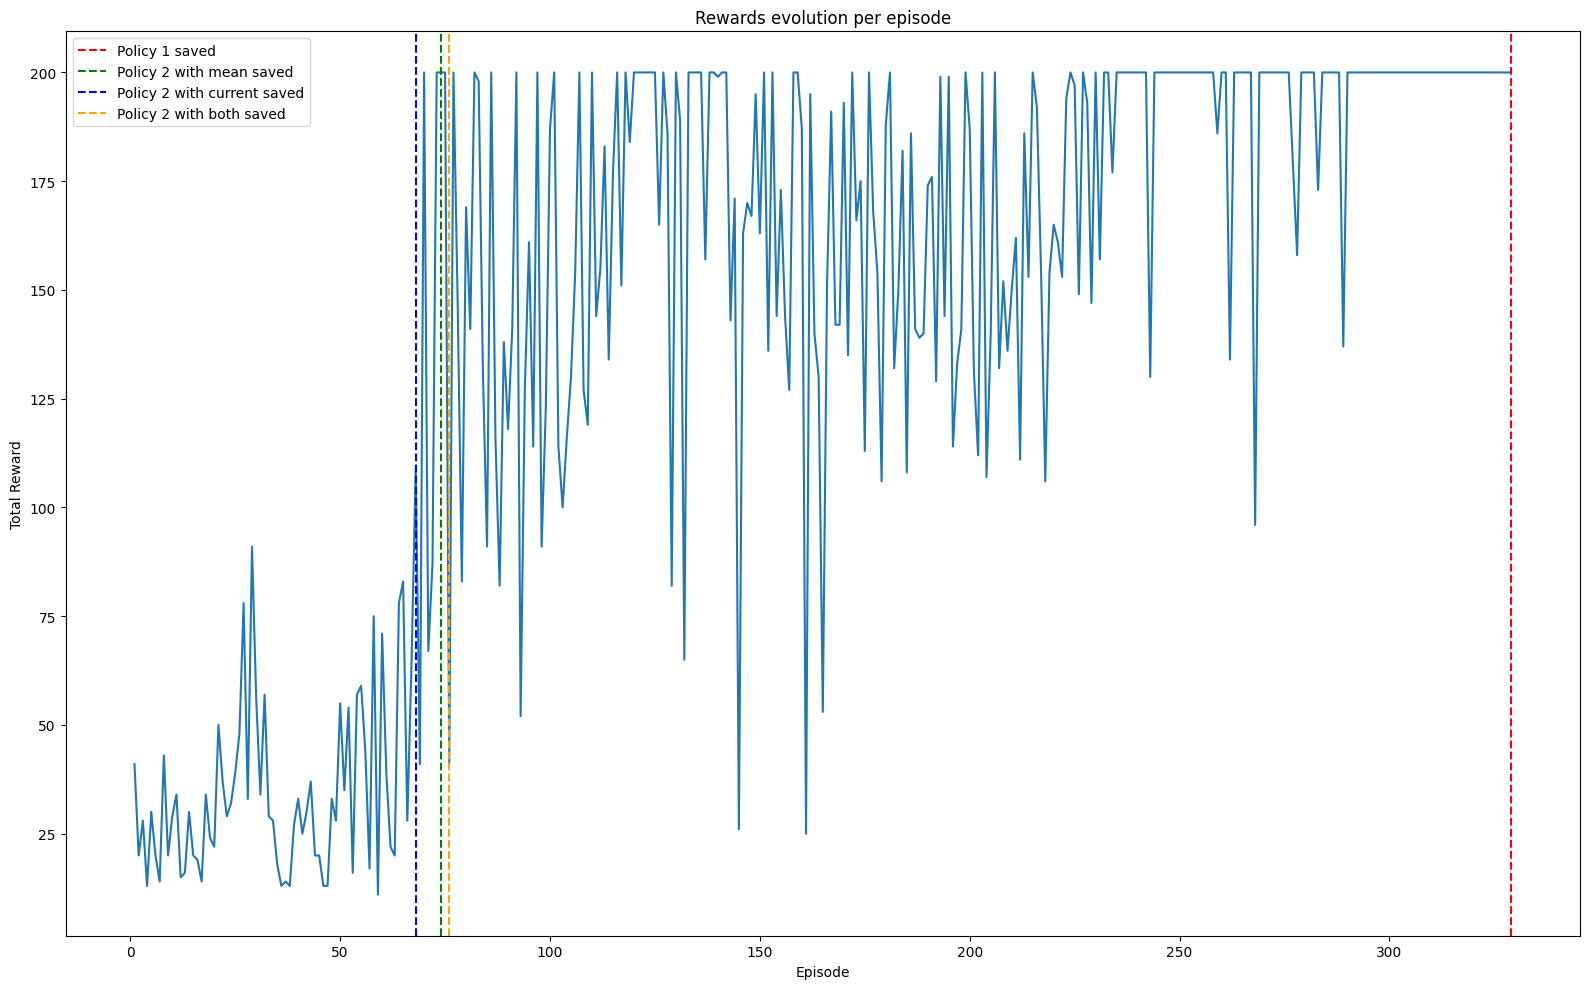

In [42]:
import matplotlib.pyplot as plt

def plot_rewards(scores, window=100, figsize=(10, 6), policy1_step=None, policy2_step_mean=None, policy2_step_point=None, policy2_step_both=None):
    episodes = list(range(1, len(scores) + 1))

    plt.figure()
    plt.plot(episodes, scores)

    if policy1_step is not None:
        plt.axvline(policy1_step, color='red', linestyle='--', label="Policy 1 saved")
    if policy2_step_mean is not None:
        plt.axvline(policy2_step_mean, color='green', linestyle='--', label="Policy 2 with mean saved")
    if policy2_step_point is not None:
        plt.axvline(policy2_step_point, color='blue', linestyle='--', label="Policy 2 with current saved")
    if policy2_step_both is not None:
        plt.axvline(policy2_step_both, color='orange', linestyle='--', label="Policy 2 with both saved")
    
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Rewards evolution per episode")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_rewards(scores, policy1_step=step_policy1, policy2_step_mean=step_policy2_mean, policy2_step_point=step_policy2_point, policy2_step_both=step_policy2_both)

In [43]:
POLICY1_NAME = "policies/policy1.pth"
POLICY2_NAME = "policies/policy2_with_mean.pth"

In [44]:
policy1 = getPolicy(ENV_NAME=ENV_NAME).to(device)
policy1.load_state_dict(torch.load(POLICY1_NAME))

policy2 = getPolicy(ENV_NAME=ENV_NAME).to(device)
policy2.load_state_dict(torch.load(POLICY2_NAME))

print(f"Generating {K} preference pairs …")
pref_data = make_pref_dataset(policy1, policy2, env, K)
pref_save(pref_data, f"pref_data/pref_data_{K}_{ENV_NAME}.pickle")
print("Finished")

Generating 1000 preference pairs …
Mean p1 199.572
Mean p2 110.726
Finished
